In [20]:
import os
import psycopg2
import datetime

import seaborn as sns
sns.set()
sns.set_style("darkgrid")
sns.set_palette("bright")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
from matplotlib.ticker import FuncFormatter
import scipy
import statsmodels.api as sm

from google.cloud import bigquery
import pandas_gbq
from google.oauth2 import service_account

credentials = service_account.Credentials.from_service_account_file('running-342013-76741001e21e.json')

project_id = 'running-342013'
client = bigquery.Client(credentials = credentials, project = project_id)

%matplotlib inline

km_in_a_mile = 1.60934

def readConfig(key):
    config = pd.read_csv(r'c:\users\lkave\documents\github\config.txt', header = None)
    config = [c.split('=') for c in config[0]]
    out = [c[1] for c in config if c[0] == key][0]
    return(out)

def dbGetQuery(q):
    dat = client.query(q).result().to_dataframe()

    return(dat)

In [22]:
ls = ['5Ks', 'half marathons']
dists = [3.11, 13.1]
for n,dist in enumerate(dists):
    dat = dbGetQuery("""SELECT start_date, distance_miles, average_pace, manual as treadmill, minutes_elapsed, rank() over (partition by manual order by minutes_elapsed) as rnk \
                        FROM runs.activities_summary \
                        WHERE distance_miles BETWEEN {} and {} \
                        ORDER BY start_date DESC""".format(dist*0.99, dist*1.01))
    dat['year'] = [c.year for c in dat.start_date]

    yearly_pr = dat.groupby(['year', 'treadmill'], as_index = False).min()[['year', 'treadmill', 'average_pace', 'minutes_elapsed', 'rnk']]

    yearly_pr['pace_mins'] = [int(np.floor(c)) for c in yearly_pr.average_pace]
    yearly_pr['pace_sec'] = [int((c - np.floor(c))*60) for c in yearly_pr.average_pace]
    #hours, rem = divmod(end-start, 3600)
    yearly_pr['time_mins'] = ['{:0>2}:{:0>2}:{:0>2}'.format(int(divmod(c, 3600)[0]), int(divmod(divmod(c, 3600)[1], 60)[0]), int(divmod(divmod(c, 3600)[1], 60)[1])) for c in yearly_pr.minutes_elapsed*60]
    print('*** Best {} by year ***\n'.format(ls[n]))
    print(yearly_pr.sort_values(['treadmill', 'rnk'], ascending = True)[['year', 'treadmill', 'pace_mins', 'pace_sec', 'time_mins']])
    print(' ')
    
for n,dist in enumerate(dists):
    dat = dbGetQuery("""SELECT CAST(EXTRACT(year from start_date) as int) as yr, distance_miles, average_pace, manual as treadmill, minutes_elapsed, rank() over (partition by manual order by minutes_elapsed) as rnk
                        FROM runs.activities_summary
                        WHERE distance_miles BETWEEN {} and {}
                        ORDER BY minutes_elapsed ASC
                        LIMIT 10""".format(dist*0.99, dist*1.01))

    dat['pace_mins'] = [int(np.floor(c)) for c in dat.average_pace]
    dat['pace_sec'] = [int((c - np.floor(c))*60) for c in dat.average_pace]
    dat['time_mins'] = ['{:0>2}:{:0>2}:{:0>2}'.format(int(divmod(c, 3600)[0]), int(divmod(divmod(c, 3600)[1], 60)[0]), int(divmod(divmod(c, 3600)[1], 60)[1])) for c in dat.minutes_elapsed*60]
    print('*** Best {} all time ***\n'.format(ls[n]))
    print(dat[['yr', 'treadmill', 'pace_mins', 'pace_sec', 'time_mins']])
    print(' ')


*** Best 5Ks by year ***

    year treadmill  pace_mins  pace_sec time_mins
7   2016         0          6        40  00:20:39
4   2014         0          6        45  00:21:13
0   2012         0          6        50  00:21:20
13  2019         0          6        55  00:21:38
6   2015         0          7         2  00:21:56
2   2013         0          7         6  00:22:04
16  2021         0          7        43  00:24:51
15  2020         0          7        44  00:26:07
9   2017         0          7        24  00:26:13
11  2018         0          8        42  00:27:44
8   2016         1          6        21  00:19:51
14  2019         1          6        35  00:20:35
3   2013         1          6        47  00:21:02
10  2017         1          6        57  00:21:38
1   2012         1          7        25  00:23:00
5   2014         1          7        54  00:24:30
12  2018         1          8        32  00:26:30
 
*** Best half marathons by year ***

   year treadmill  pace_mins  pace_

# YTD activities

In [23]:
dat = dbGetQuery("""SELECT * FROM runs.activities_summary WHERE lower(type) = 'run' ORDER BY start_date""")
print(dat[['name', 'start_date', 'distance_miles', 'average_pace', 'manual', 'type']].tail(10))

# dat = dat.append(dat.tail(1)).reset_index(drop = True)
# dat.loc[len(dat)-1, 'start_date'] = datetime.datetime.now()
# dat.loc[len(dat)-1, 'distance'] = 0

dat['year'] = [c.year for c in dat.start_date]
dat['doy'] = [c.timetuple().tm_yday for c in dat.start_date]

dat['distance_miles'] = [c for c in dat.distance_miles]
dat['ytd_distance'] = dat.groupby('year', as_index = False).cumsum()['distance_miles']
dat['generic_date'] = [datetime.date(1904,c.month,c.day) for c in dat.start_date]


              name                start_date  distance_miles  average_pace  \
1438  Morning Run  2022-01-31 06:35:55+00:00        4.672599     10.053311   
1439  Morning Run  2022-02-03 06:30:00+00:00        5.260914      8.400329   
1440  Morning Run  2022-02-04 06:38:19+00:00        4.834404      8.840555   
1441  Morning Run  2022-02-07 06:36:26+00:00        4.830924      8.337659   
1442  Morning Run  2022-02-11 06:34:45+00:00        4.626741      8.814409   
1443  Morning Run  2022-02-12 07:26:48+00:00        8.951620     10.324184   
1444  Morning Run  2022-02-15 06:33:27+00:00        3.898679      8.275918   
1445  Morning Run  2022-02-18 07:06:07+00:00        2.541414      8.688774   
1446  Morning Run  2022-02-20 09:31:34+00:00        5.325661      8.286145   
1447  Morning Run  2022-02-21 06:38:22+00:00        4.669368      9.249049   

     manual type  
1438      0  Run  
1439      0  Run  
1440      0  Run  
1441      0  Run  
1442      0  Run  
1443      0  Run  
1444    

In [24]:
target = 200

dat = dat[['start_date', 'generic_date', 'year', 'ytd_distance', 'distance_miles', 'doy']]

actual = dat.loc[dat.start_date == max(dat.start_date), 'ytd_distance'].item()

plot_dat = dat[['generic_date', 'year', 'ytd_distance']]
plot_dat = plot_dat.groupby(['generic_date', 'year'], as_index = False).max()
plot_dat = plot_dat.pivot_table(index = 'generic_date', columns = 'year')
plot_dat.columns = plot_dat.columns.droplevel().rename(None)
plot_dat = plot_dat.reset_index()
plot_dat = plot_dat.apply(lambda series: series.loc[:series.last_valid_index()].ffill())

x = range(len(plot_dat))
y = [(target / len(plot_dat)) * x for x in x]
plot_dat['target'] = y
t = datetime.datetime.today().date()
today_target = plot_dat.loc[plot_dat.generic_date == datetime.date(1904, t.month, t.day), 'target'].item()

In [25]:
lin = plot_dat[['generic_date', t.year]].copy()
lin = lin.where(lin.ffill().notna(), 0)
a = np.where(pd.isnull(lin[t.year]))[0][0]
b = np.where(lin.generic_date == datetime.datetime.today().replace(year = 1904).date())[0][0]
lin.loc[a:b, t.year] = lin.loc[a-1, t.year]

y = list(lin.loc[~pd.isnull(lin[t.year]), t.year])
x = list(range(len(y)))
w = x[::-1]
w = [np.exp(-c/10) for c in w]
x = sm.add_constant(x)
m = sm.WLS(y, x, w)
results = m.fit()
lin['pred'] = [c*results.params[1] + results.params[0] for c in list(lin.index)]

C:\Users\lkave\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\lkave\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\lkave\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


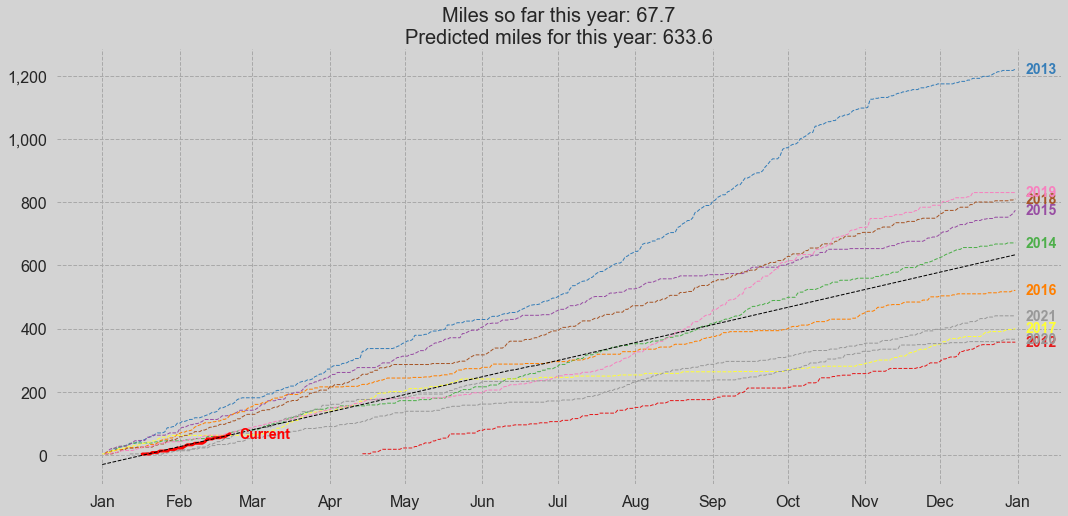

In [26]:
fig = plt.figure(figsize = (18,8))
ax = fig.add_subplot(111)

colors = cm.Set1
for n,y in enumerate(plot_dat.columns[1:]):
    if y == 'target':
        continue
        ax.plot(plot_dat.generic_date, plot_dat[y], linestyle = '--', color = 'k', linewidth = 2)
        ax.text(plot_dat.generic_date[-1:]+datetime.timedelta(4), np.nanmax(plot_dat[y]), 'Target', ha = 'left', va = 'center', fontweight = 'bold', color = 'k', fontsize = 14)
    elif y == max([int(c) for c in plot_dat.columns[1:-1]]):
        ax.plot(plot_dat.generic_date, plot_dat[y], linewidth = 3, color = 'red')
        ax.text(max(plot_dat.loc[~pd.isnull(plot_dat[y]), 'generic_date'])+datetime.timedelta(4), np.nanmax(plot_dat[y]), 'Current', ha = 'left', va = 'center', fontweight = 'bold', color = 'red', fontsize = 14)
    else:
        ax.plot(plot_dat.generic_date, plot_dat[y].ffill(), linestyle = '--', linewidth = 1, color = colors(n))
        ax.text(plot_dat.generic_date[-1:]+datetime.timedelta(4), np.nanmax(plot_dat[y]), y, ha = 'left', va = 'center', fontweight = 'bold', color = colors(n), fontsize = 14)

ax.plot(lin.generic_date, lin['pred'], linestyle = '--', linewidth = 1, color = 'black')
# ax.text(lin.generic_date[-1:]+datetime.timedelta(4), np.nanmax(lin['pred']), 'Prediction', ha = 'left', va = 'center', fontweight = 'bold', color = 'black', fontsize = 14)

for var in ['top', 'bottom', 'left', 'right']:
    ax.spines[var].set_visible(False)
    
ax.grid(linestyle = '--', color = 'darkgrey')

# ax.set_title('Target: {:,.1f} miles | Actual: {:,.1f} miles | Surplus: {:,.1f} miles\nPrediction: {:,.1f} miles'.format(today_target, actual, actual - today_target, lin.tail(1).pred.item()), fontsize = 20)
ax.set_title('Miles so far this year: {:,.1f}\nPredicted miles for this year: {:,.1f}'.format(actual, lin.tail(1).pred.item()), fontsize = 20)
# ax.set_title(' Target: ' + str(round(today_target,1)) + ' miles |' + \
#             ' Actual: ' + str(round(actual,1)) + ' miles |' + \
#             ' Surplus: ' + str(round(actual - today_target,1)) + ' miles', fontsize = 20)

ax.set_xticks([datetime.date(1904,c,1) for c in range(1,13)] + [datetime.date(1905,1,1)])
xfmt = mdates.DateFormatter('%b')
ax.get_figure().set_facecolor('lightgrey')
ax.set_facecolor('lightgrey')
ax.xaxis.set_major_formatter(xfmt)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:,.0f}'.format(float(y))))
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(16)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(16)

No handles with labels found to put in legend.


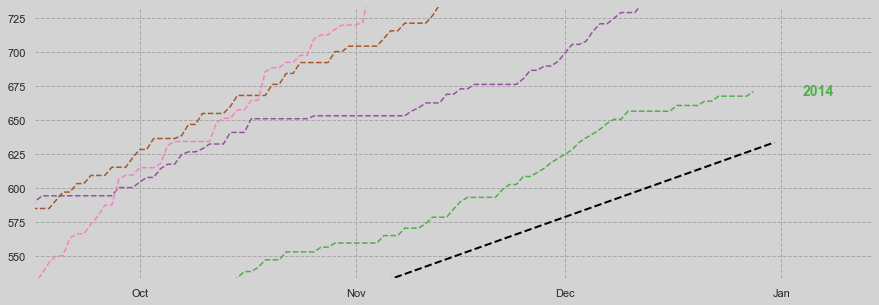

In [27]:
fig = plt.figure(figsize = (15,5))
ax = fig.add_subplot(111)

maxdistance = list(lin.pred)[-1]

colors = cm.Set1
for n,y in enumerate(plot_dat.columns[1:]):
    if y == 'target':
        ax.plot(lin.generic_date, lin['pred'], linestyle = '--', linewidth = 2, color = 'black')
        if abs(np.nanmax(plot_dat[y]) - maxdistance) < 100:
            ax.text(plot_dat.generic_date[-1:]+datetime.timedelta(4), np.nanmax(plot_dat[y]), 'Target', ha = 'left', va = 'center', fontweight = 'bold', color = 'k', fontsize = 14)
    elif y == max([int(c) for c in plot_dat.columns[1:-1]]):
        ax.plot(plot_dat.generic_date, plot_dat[y], linewidth = 3, color = 'red')
        if abs(np.nanmax(plot_dat[y]) - maxdistance) < 100:
            ax.text(max(plot_dat.loc[~pd.isnull(plot_dat[y]), 'generic_date'])+datetime.timedelta(4), np.nanmax(plot_dat[y]), 'Current', ha = 'left', va = 'center', fontweight = 'bold', color = 'red', fontsize = 14)
    else:
        ax.plot(plot_dat.generic_date, plot_dat[y], linestyle = '--', color = colors(n))
        if abs(np.nanmax(plot_dat[y]) - maxdistance) < 100:
            ax.text(plot_dat.generic_date[-1:]+datetime.timedelta(4), np.nanmax(plot_dat[y]), y, ha = 'left', va = 'center', fontweight = 'bold', color = colors(n), fontsize = 14)

ax.legend(frameon = False)
for var in ['top', 'bottom', 'left', 'right']:
    ax.spines[var].set_visible(False)
    
ax.grid(linestyle = '--', color = 'darkgrey')

ax.set_xticks([datetime.date(1904,c,1) for c in range(1,13)] + [datetime.date(1905,1,1)])

maxdate = plot_dat.loc[plot_dat[plot_dat.columns[-2]] == np.nanmax(plot_dat[plot_dat.columns[-2]]), 'generic_date'].head(1).item()
maxdate = datetime.date(1904,11,15)
ax.set_xlim(maxdate - datetime.timedelta(60), maxdate + datetime.timedelta(60))

ax.set_ylim(max(maxdistance - 100,0), maxdistance + 100)

xfmt = mdates.DateFormatter('%b')
ax.get_figure().set_facecolor('lightgrey')
ax.set_facecolor('lightgrey')
ax.xaxis.set_major_formatter(xfmt)

No handles with labels found to put in legend.


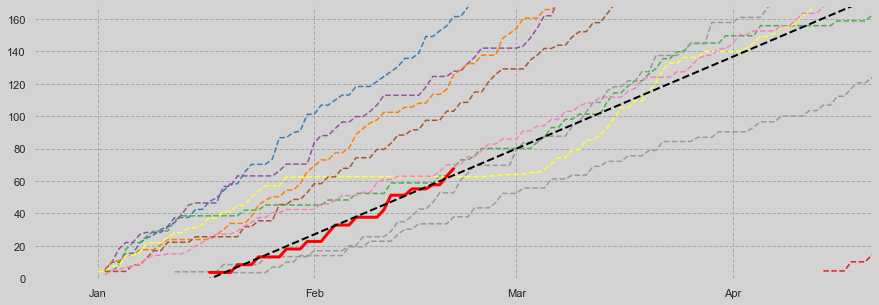

In [28]:
fig = plt.figure(figsize = (15,5))
ax = fig.add_subplot(111)

for n,y in enumerate(plot_dat.columns[1:]):
    if y == 'target':
        ax.plot(lin.generic_date, lin['pred'], linestyle = '--', linewidth = 2, color = 'black')
#         ax.plot(plot_dat.generic_date, plot_dat[y], linestyle = '--', color = 'k')
    elif y == max([int(c) for c in plot_dat.columns[1:-1]]):
        ax.plot(plot_dat.generic_date, plot_dat[y], linewidth = 3, color = 'red')
    else:
        ax.plot(plot_dat.generic_date, plot_dat[y], linestyle = '--', color = colors(n))

ax.legend(frameon = False)
for var in ['top', 'bottom', 'left', 'right']:
    ax.spines[var].set_visible(False)
    
ax.grid(linestyle = '--', color = 'darkgrey')

ax.set_xticks([datetime.date(1904,c,1) for c in range(1,13)] + [datetime.date(1905,1,1)])

maxdate = plot_dat.loc[plot_dat[plot_dat.columns[-2]] == np.nanmax(plot_dat[plot_dat.columns[-2]]), 'generic_date'].head(1).item()
ax.set_xlim(maxdate - datetime.timedelta(60), maxdate + datetime.timedelta(60))

maxdistance = np.nanmax(plot_dat[plot_dat.columns[-2]])
ax.set_ylim(max(maxdistance - 100,0), maxdistance + 100)

xfmt = mdates.DateFormatter('%b')
ax.get_figure().set_facecolor('lightgrey')
ax.set_facecolor('lightgrey')
ax.xaxis.set_major_formatter(xfmt)

# Miles by weekday

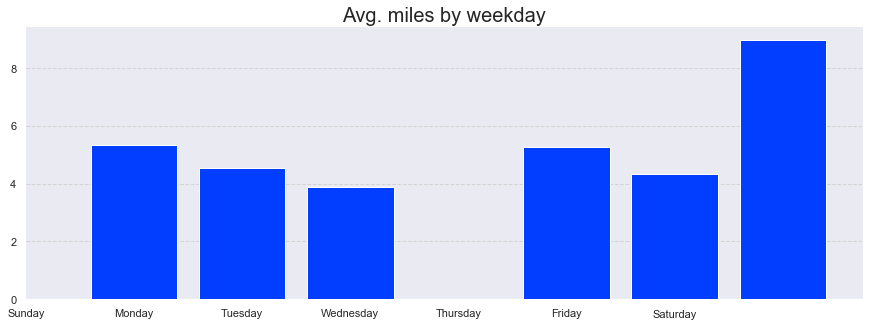

In [30]:
dat = dbGetQuery("""SELECT EXTRACT(dayofweek from start_date) as dow, avg(distance_miles) as total_miles \
                FROM runs.activities_summary \
                WHERE EXTRACT(year from start_date) = (SELECT max(EXTRACT(year from start_date)) FROM runs.activities) \
                AND lower(type) = 'run'
                GROUP BY 1 \
                ORDER BY 1""")

fig = plt.figure(figsize = (15,5))
ax = fig.add_subplot(111)

ax.bar(dat.dow, dat.total_miles, zorder = 3)
ax.set_xticks([0,1,2,3,4,5,6])

for var in ['top', 'left', 'right']:
    ax.spines[var].set_visible(False)
    
ax.grid(linestyle = '--', color = 'lightgrey')
ax.xaxis.grid(False)
ax.set_title('Avg. miles by weekday', fontsize = 20)
x = ax.set_xticklabels(['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])

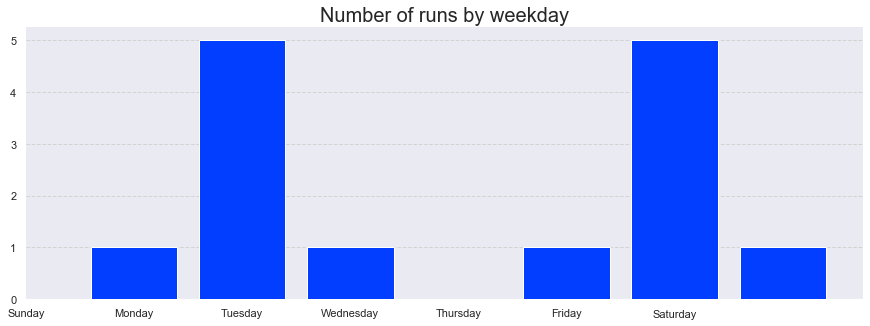

In [31]:
dat = dbGetQuery("""SELECT EXTRACT(dayofweek from start_date) as dow, count(distance_miles) as num_activities \
                FROM runs.activities_summary \
                WHERE EXTRACT(year from start_date) = (SELECT max(EXTRACT(year from start_date)) FROM runs.activities) \
                AND lower(type) = 'run'
                GROUP BY 1 \
                ORDER BY 1""")

fig = plt.figure(figsize = (15,5))
ax = fig.add_subplot(111)

ax.bar(dat.dow, dat.num_activities, zorder = 3)
ax.set_xticks([0,1,2,3,4,5,6])

for var in ['top', 'left', 'right']:
    ax.spines[var].set_visible(False)
    
ax.grid(linestyle = '--', color = 'lightgrey')
ax.xaxis.grid(False)
ax.set_title('Number of runs by weekday', fontsize = 20)
x = ax.set_xticklabels(['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])

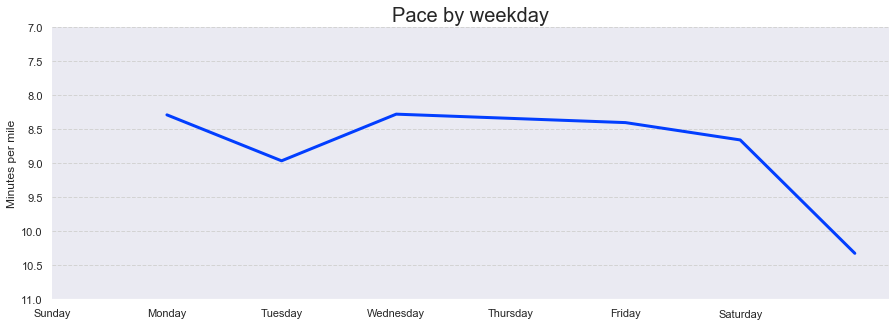

In [32]:
dat = dbGetQuery("""SELECT EXTRACT(dayofweek from start_date) as dow, sum(average_pace * distance_miles) / sum(distance_miles) as avg_pace \
                FROM runs.activities_summary \
                WHERE EXTRACT(year from start_date) = (SELECT max(EXTRACT(year from start_date)) FROM runs.activities) \
                AND lower(type) = 'run'
                GROUP BY 1 \
                ORDER BY 1""")

fig = plt.figure(figsize = (15,5))
ax = fig.add_subplot(111)

ax.plot(dat.dow, dat.avg_pace, linewidth = 3)

for var in ['top', 'left', 'right']:
    ax.spines[var].set_visible(False)
    
ax.grid(linestyle = '--', color = 'lightgrey')
ax.xaxis.grid(False)
ax.set_ylim([7,11])
ax.invert_yaxis()
ax.set_ylabel('Minutes per mile')
ax.set_title('Pace by weekday', fontsize = 20)
ax.set_xticks([0,1,2,3,4,5,6])
x = ax.set_xticklabels(['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])

# Average pace

In [33]:
dat = dbGetQuery("""SELECT start_date, average_speed, distance FROM runs.activities \
                    WHERE lower(type) = 'run'
                    and average_speed > 3""")
dat = dat.sort_values('start_date').reset_index(drop = True)
dat['month'] = [datetime.date(c.year, c.month, 1) for c in dat.start_date]
dat['average_pace'] = [(km_in_a_mile/60)/((0.00001+c) / 1000) for c in dat.average_speed]
dat.distance = [(c/1000)/km_in_a_mile for c in dat.distance]

In [38]:
out = pd.DataFrame(columns = ['date', 'average_pace_7', 'average_pace_30', 'average_pace_YTD'])

for i in range(len(dat)):
    dat_7 = dat.loc[(dat.start_date <= dat.start_date[i]) & (dat.start_date >= (dat.start_date[i] - datetime.timedelta(7)))]
    dat_30 = dat.loc[(dat.start_date <= dat.start_date[i]) & (dat.start_date >= (dat.start_date[i] - datetime.timedelta(30)))]
    dat_YTD = dat.loc[(dat.start_date <= dat.start_date[i]) & (dat.start_date >= pd.Timestamp(datetime.date(dat.start_date[i].year,1,1), tz='UTC'))]

    pace_y = pace_30 = pace_YTD = None
    if len(dat_7) > 0:
        pace_7 = np.nansum(dat_7.distance * dat_7.average_pace) / np.nansum(dat_7.distance)
    if len(dat_30) > 0:
        pace_30 = np.nansum(dat_30.distance * dat_30.average_pace) / np.nansum(dat_30.distance)
    if len(dat_YTD) > 0:
        pace_YTD = np.nansum(dat_YTD.distance * dat_YTD.average_pace) / np.nansum(dat_YTD.distance)

    out = out.append(pd.DataFrame([[dat.start_date[i].date(),
                            pace_7,
                            pace_30,
                            pace_YTD]], columns = ['date', 'average_pace_7', 'average_pace_30', 'average_pace_YTD']
                         ))
out = out.sort_values('date')

In [40]:
out.head()

,date,average_pace_7,average_pace_30,average_pace_YTD
0,2012-04-14,8.225161,8.225161,8.225161
0,2012-04-14,8.403384,8.403384,8.403384
0,2012-04-18,8.534525,8.534525,8.534525
0,2012-04-21,8.473378,8.473378,8.473378
0,2012-04-21,8.489351,8.462386,8.462386


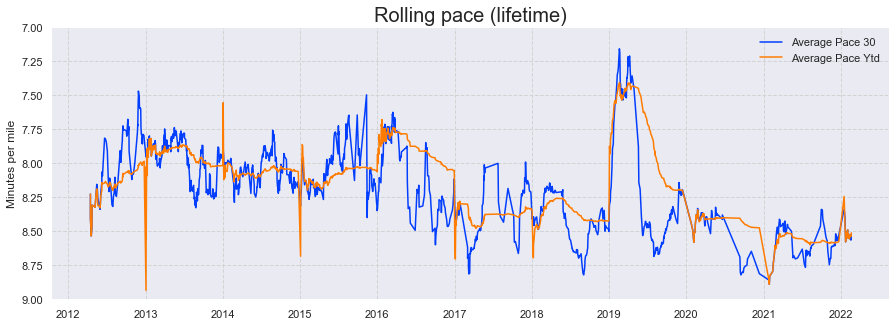

In [46]:
fig = plt.figure(figsize = (15,5))
ax = fig.add_subplot(111)

for y in out.columns[2:]:
    ax.plot(out.date, out[y], label = y.replace('_', ' ').title())

ax.legend(frameon = False)
for var in ['top', 'bottom', 'left', 'right']:
    ax.spines[var].set_visible(False)
    
ax.grid(linestyle = '--', color = 'lightgrey')
ax.set_title('Rolling pace (lifetime)', fontsize = 20)
ax.set_ylim(7, 9)
ax.invert_yaxis()
ax.set_ylabel('Minutes per mile')

xfmt = mdates.DateFormatter('%Y')
ax.xaxis.set_major_formatter(xfmt)

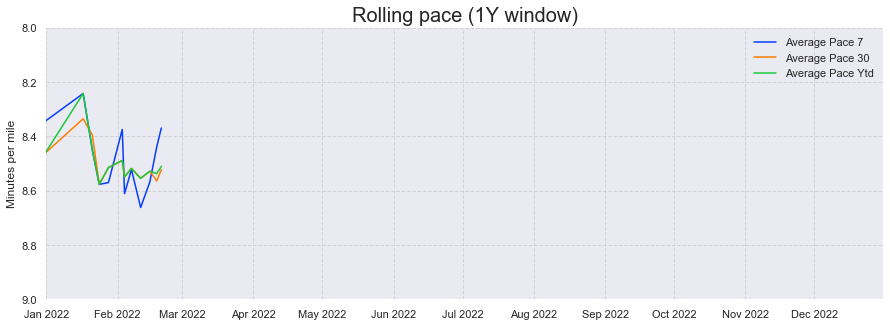

In [47]:
fig = plt.figure(figsize = (15,5))
ax = fig.add_subplot(111)

for y in out.columns[1:]:
    ax.plot(out.date, out[y], label = y.replace('_', ' ').title())

ax.legend(frameon = False)
for var in ['top', 'bottom', 'left', 'right']:
    ax.spines[var].set_visible(False)
    
ax.grid(linestyle = '--', color = 'lightgrey')

ax.set_title('Rolling pace (1Y window)', fontsize = 20)
ax.set_xlim(datetime.date(max(out.date).year-0, 1, 1), datetime.date(max(out.date).year, 12, 31))
ax.set_ylim(8,9)
ax.invert_yaxis()
ax.set_ylabel('Minutes per mile')

# ax.plot([datetime.date(2019,1,1), datetime.date(2019,12,31)], [6.4, 6.4], color = 'red', linestyle = '--')
# ax.text(x = datetime.date(2019,1,1), y = 6.3, s = 'Race pace goal', color = 'red')

xfmt = mdates.DateFormatter('%b %Y')
ax.xaxis.set_major_formatter(xfmt)

## High mileage weeks

In [48]:
lim = 20

dat = dbGetQuery("""SELECT start_date, distance_miles FROM runs.activities_summary WHERE lower(type) = 'run'""")
dat = dat.sort_values('start_date')
dat['weeknum'] = [(c - datetime.timedelta(c.weekday())).date() for c in dat.start_date]
dat = dat.groupby('weeknum', as_index = False).sum()
dat = dat.sort_values('weeknum')
dat = dat.loc[dat.distance_miles >= lim]
dat.weeknum = [c.strftime("%d %b, '%y") for c in dat.weeknum]
dat = dat.reset_index(drop = True)

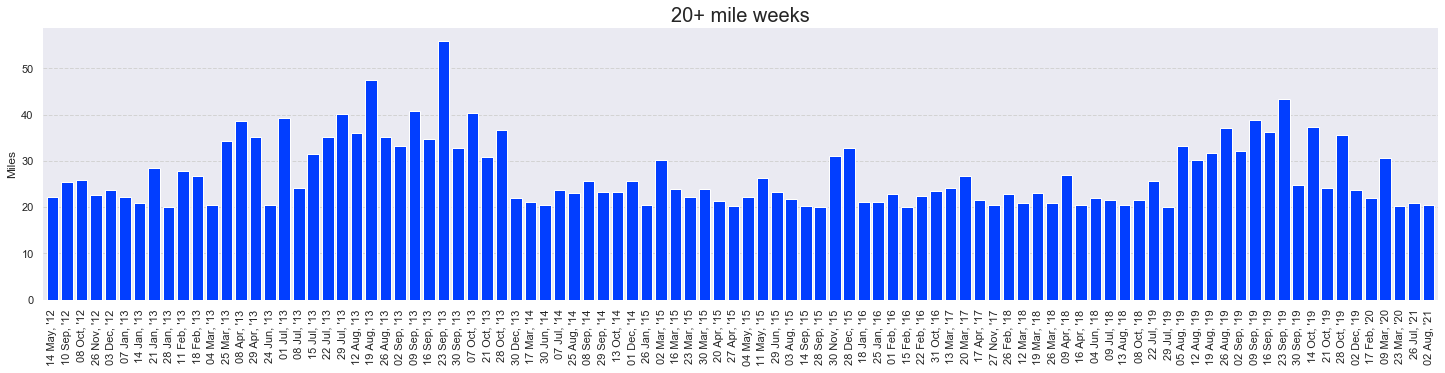

In [49]:
fig = plt.figure(figsize = (25,5))
ax = fig.add_subplot(111)

dat = dat.set_index('weeknum')
dat.plot(kind = 'bar', ax = ax, width = 0.8)

ax.legend_.remove()
for var in ['top', 'bottom', 'left', 'right']:
    ax.spines[var].set_visible(False)

ax.set_xlabel('')
ax.set_ylabel('Miles')
ax.set_title('{}+ mile weeks'.format(lim), fontsize = 20)
ax.grid(linestyle = '--', color = 'lightgrey')
ax.xaxis.grid(False)

# Monthly elevation gain

In [55]:
dat = dbGetQuery("""SELECT start_date, total_elevation_gain * 3.28084 as total_elevation_gain FROM runs.activities WHERE lower(type) = 'run' AND date(start_date) > date_sub(current_date, interval 5 year)""")
dat = dat.sort_values('start_date')
dat['month'] = [datetime.date(c.year, c.month, 1) for c in dat.start_date]
dat = dat.groupby('month', as_index = False).sum()
dat = dat.sort_values('month')

dat.month = [c.strftime('%b-%y') for c in dat.month]
dat = dat.reset_index(drop = True)

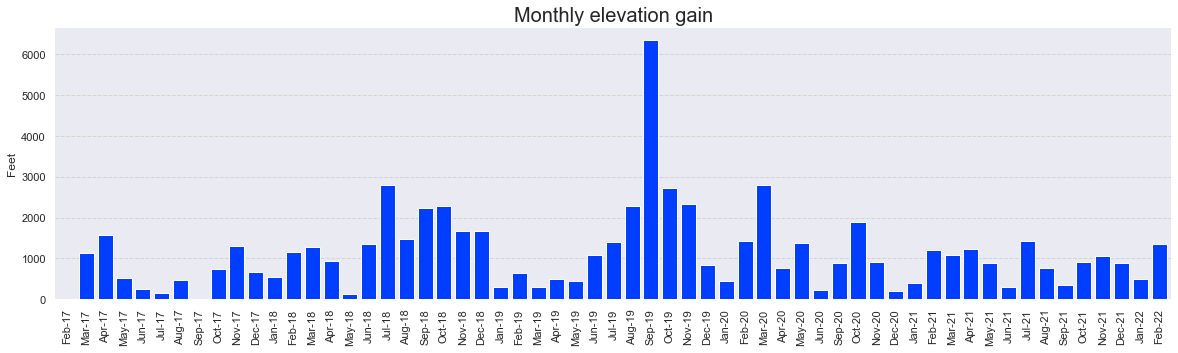

In [56]:
fig = plt.figure(figsize = (20,5))
ax = fig.add_subplot(111)

dat = dat.set_index('month')
dat.plot(kind = 'bar', ax = ax, width = 0.8)

ax.legend_.remove()
for var in ['top', 'bottom', 'left', 'right']:
    ax.spines[var].set_visible(False)

ax.set_xlabel('')
ax.set_ylabel('Feet')
ax.set_title('Monthly elevation gain', fontsize = 20)
ax.grid(linestyle = '--', color = 'lightgrey')
ax.xaxis.grid(False)

# Monthly mileage

In [57]:
dat = dbGetQuery("""SELECT start_date, distance FROM runs.activities WHERE lower(type) = 'run' AND date(start_date) > date_sub(current_date, interval 5 year)""")
dat.distance = [(c/1000)/km_in_a_mile for c in dat.distance]
dat = dat.sort_values('start_date')
dat['month'] = [datetime.date(c.year, c.month, 1) for c in dat.start_date]
dat = dat.groupby('month', as_index = False).sum()
dat = dat.sort_values('month')
dat.month = [c.strftime('%b-%y') for c in dat.month]
dat = dat.reset_index(drop = True)
dat = dat.set_index('month')

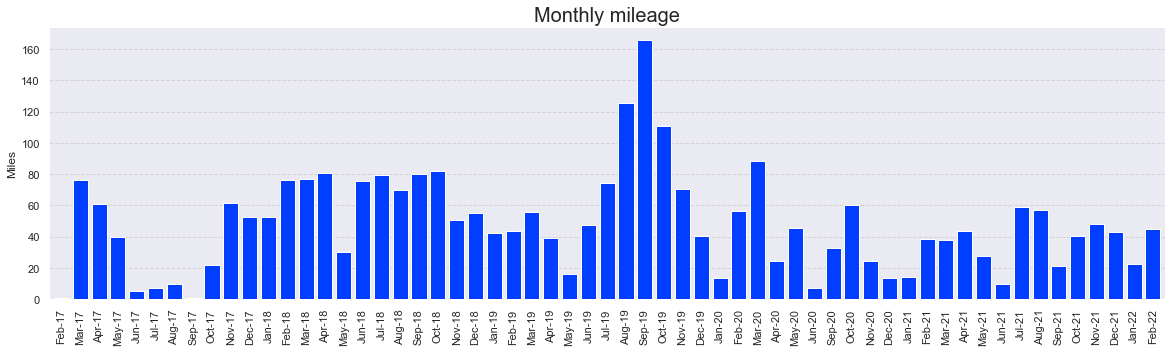

In [58]:
fig = plt.figure(figsize = (20,5))
ax = fig.add_subplot(111)

dat.plot(kind = 'bar', ax = ax, width = 0.8)

ax.legend().remove()
for var in ['top', 'bottom', 'right']:
    ax.spines[var].set_visible(False)

ax.set_xlabel('')
ax.set_ylabel('Miles')
ax.set_title('Monthly mileage', fontsize = 20)
ax.grid(linestyle = '--', color = 'lightgrey')
ax.xaxis.grid(False)

## Monthly elevation rate (feet of elevation per mile run)

In [59]:
dat = dbGetQuery("""SELECT start_date, (total_elevation_gain * 3.28084) as total_elevation_gain, distance FROM runs.activities WHERE lower(type) = 'run' AND date(start_date) > date_sub(current_date, interval 5 year)""")
dat.distance = [(c/1000)/km_in_a_mile for c in dat.distance]

In [60]:
dat['elevation_rate'] = dat.total_elevation_gain / dat.distance
dat = dat.sort_values('start_date')
dat['month'] = [datetime.date(c.year, c.month, 1) for c in dat.start_date]
dat = dat.groupby('month', as_index = False).sum()
dat = dat.sort_values('month')
dat.month = [c.strftime('%b-%y') for c in dat.month]
dat = dat.reset_index(drop = True)
dat = dat.set_index('month')
#dat = dat[['elevation_rate']]

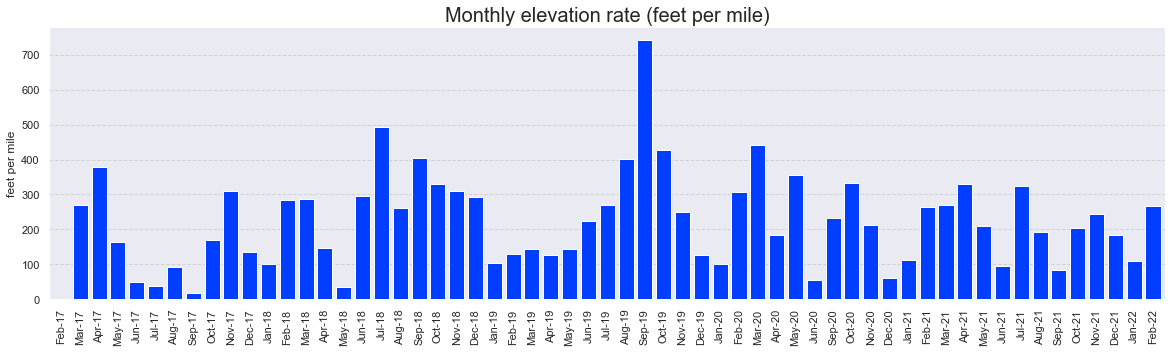

In [61]:
fig = plt.figure(figsize = (20,5))
ax = fig.add_subplot(111)

dat.elevation_rate.plot(kind = 'bar', ax = ax, width = 0.8)

ax.legend().remove()
for var in ['top', 'bottom', 'right']:
    ax.spines[var].set_visible(False)

ax.set_xlabel('')
ax.set_ylabel('feet per mile')
ax.set_title('Monthly elevation rate (feet per mile)', fontsize = 20)
ax.grid(linestyle = '--', color = 'lightgrey')
ax.xaxis.grid(False)

## Cadence

In [62]:
dat = dbGetQuery("""
    SELECT *
    FROM runs.activities_summary
    WHERE date(start_date) > date_sub(current_date, interval 3 year)
    AND type = 'Run'
    AND average_cadence IS NOT NULL
    ORDER BY 1 ASC""")

dat['rolling_avg_cadence'] = dat.average_cadence.rolling(7).mean()
dat['cadence_adj'] = dat.average_cadence / dat.average_pace

dat['rolling_weighted_avg_cadence'] = None
for i in range(6, len(dat), 1):
    x = dat.average_cadence[(i-6):(i+1)]
    y = dat.distance_miles[(i-6):(i+1)]
    y = y / sum(y)
    wavg = sum([a*b for a,b in zip(x,y)])
    dat.loc[i, 'rolling_weighted_avg_cadence'] = wavg
    
dat.tail()

,start_date,distance_miles,minutes_elapsed,average_pace,average_cadence,total_elevation_gain,manual,name,type,rolling_avg_cadence,cadence_adj,rolling_weighted_avg_cadence
289,2022-02-12 07:26:48+00:00,8.951620,119.883333,10.324184,163.4,80.0,0,Morning Run,Run,169.485714,15.826917,168.848608
290,2022-02-15 06:33:27+00:00,3.898679,33.233333,8.275918,174.2,48.0,0,Morning Run,Run,169.914286,21.049024,169.101017
291,2022-02-18 07:06:07+00:00,2.541414,24.900000,8.688774,171.2,21.0,0,Morning Run,Run,169.857143,19.703585,168.91952
292,2022-02-20 09:31:34+00:00,5.325661,46.833333,8.286145,173.6,77.0,0,Morning Run,Run,170.085714,20.950636,169.16861
293,2022-02-21 06:38:22+00:00,4.669368,52.600000,9.249049,168.0,26.0,0,Morning Run,Run,170.142857,18.164030,169.229642


C:\Users\lkave\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\lkave\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\lkave\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\lkave\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be r

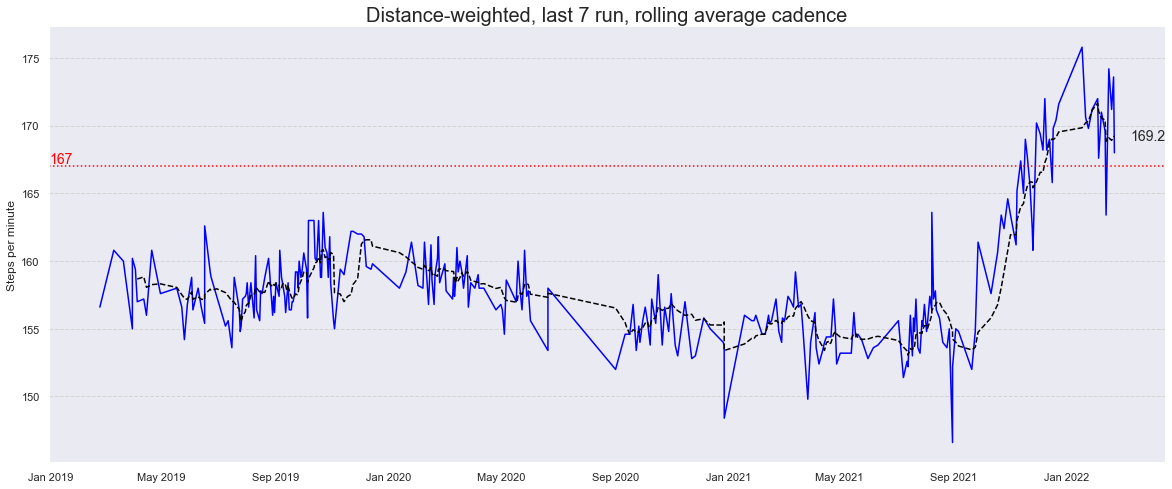

In [63]:
fig = plt.figure(figsize = (20,8))
ax = fig.add_subplot(111)

ax.plot(dat.start_date, dat.average_cadence, color = 'blue')
# ax.plot(dat.start_date, dat.rolling_avg_cadence, color = 'black', ls = '--')
ax.plot(dat.start_date, dat.rolling_weighted_avg_cadence, color = 'black', ls = '--')

ax.legend().remove()
for var in ['top', 'bottom', 'right']:
    ax.spines[var].set_visible(False)

ax.axhline(167, color = 'red', ls = ':')
ax.text(ax.get_xlim()[0], 167, '167', color = 'red', fontsize = 14, ha = 'left', va = 'bottom')
ax.text(ax.get_xlim()[1], dat.rolling_weighted_avg_cadence[len(dat)-1], '{:,.1f}'.format(dat.rolling_weighted_avg_cadence[len(dat)-1]), fontsize = 14, ha = 'right', va = 'center')
# ax.text(ax.get_xlim()[1], dat.average_cadence[len(dat)-1], '{:,.1f}'.format(dat.average_cadence[len(dat)-1]), fontsize = 14, ha = 'right', va = 'center', color = 'blue')
ax.set_xlabel('')
ax.set_ylabel('Steps per minute')
ax.set_title('Distance-weighted, last 7 run, rolling average cadence', fontsize = 20)
ax.grid(linestyle = '--', color = 'lightgrey')
xfmt = mdates.DateFormatter('%b %Y')
ax.xaxis.set_major_formatter(xfmt)
ax.xaxis.grid(False)

C:\Users\lkave\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\lkave\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\lkave\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\lkave\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be r

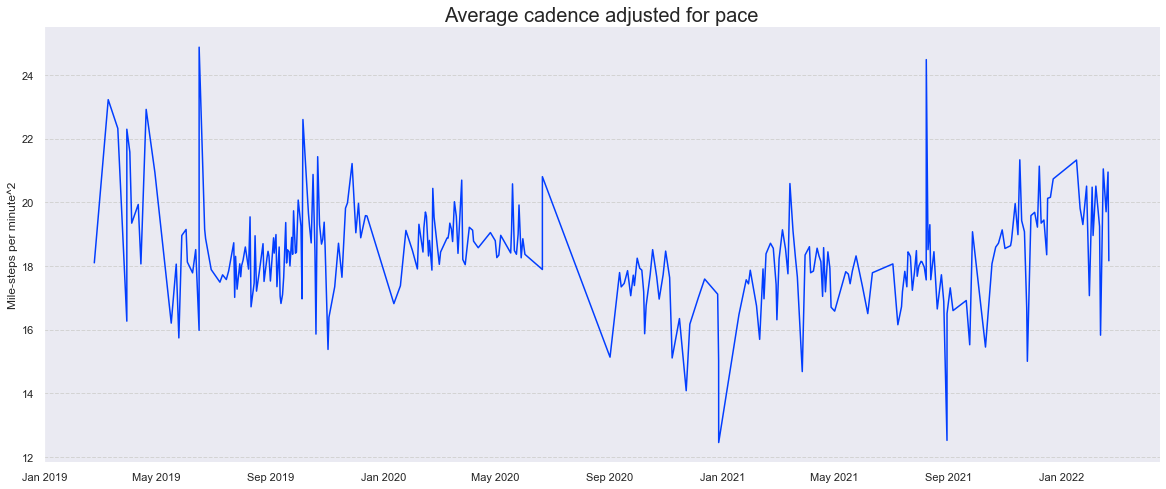

In [64]:
fig = plt.figure(figsize = (20,8))
ax = fig.add_subplot(111)

ax.plot(dat.start_date, dat.cadence_adj)

ax.legend().remove()
for var in ['top', 'bottom', 'right']:
    ax.spines[var].set_visible(False)

ax.set_xlabel('')
ax.set_ylabel('Mile-steps per minute^2')
ax.set_title('Average cadence adjusted for pace', fontsize = 20)
ax.grid(linestyle = '--', color = 'lightgrey')
xfmt = mdates.DateFormatter('%b %Y')
ax.xaxis.set_major_formatter(xfmt)
ax.xaxis.grid(False)